# Denoising Diffusion Probabilistic Models with miniai 

Now that we written our own barebones training library, let's make some progress towards exploring diffusion model and building Stable Diffusion from scratch.

We'll start with building and training the model described in the seminal 2020 paper Denoising Diffusion Probabilistic Models (DDPM). For more context, while diffusion models were technically invented back in 2015, diffusion models flew under the radar until this 2020 paper since they were complicated and difficult to train. The 2020 paper introducing DDPMs made some crucial assumptions that significantly simplify the model training and generation processes, as we will see here. Later versions of diffusion models all build upon the same framework introduced in this paper.

Let's get started and train our own DDPM!

## Imports

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [ ]:
mpl.rcParams['image.cmap'] = 'gray'
plt.style.use('dark_background')
logging.disable(logging.WARNING)

## Load the dataset

In [ ]:
x,y = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

To make life simpler (mostly with the model architecture), we'll resize the 28x28 images to 32x32:

In [ ]:
@inplace 
def transformi(b): b[x] = [TF.resize(TF.to_tensor(o), (32,32)) for o in b[x]]

Let's set our batch size and create our DataLoaders with this batch size. we can confirm the shapes are correct. Note that while we do get the labels for the dataset, we actuallydon't care about that for our task of unconditional image generation.

In [ ]:
set_seed(42)
bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb[:10]

(torch.Size([128, 1, 32, 32]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

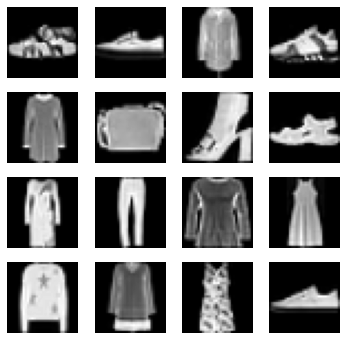

In [ ]:
show_images(xb[:16], imsize=1.5)

## Create model

We will create a U-net. A U-net looks something like this:

![alt text](unet.jpeg)

The DDPM U-net is a modification of this with some modern tricks like using attention.

We will cover how U-nets are created and how modules like attention work in future lessons. For now, we'll import the U-net from the diffusers library:

In [ ]:
from diffusers import UNet2DModel

In [ ]:
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32,64,128,128))

## Training - easy with a callback!

DDPM is trained quite simply in a few steps:

1. Randomly select some timesteps in an iterative noising process.
2. Add noise corresponding to this timestep to the original image. For increasing timesteps, the variance of the noise increases.
3. Pass in this noisy image and the timestep to our model
4. Model is trained with an MSE loss between the model output and the amount of noise added to the image

We will implement this in a callback. The callback will randomly select the timestep and create the noisy image before setting up our input and ground truth tensors for the model forward pass and loss calculation.

After training, we need to sample from this model. This is an iterative denoising process starting from pure noise. We simply keep removing noise predicted by the neural network, but we do it with an expected noise schedule that is reverse of what we saw during training. This is also done in our callback.

In [ ]:
??TrainCB

Init signature: TrainCB(n_inp=1)
Source:        
class TrainCB(Callback):
    """Basic training callback"""
    # n_inp allows to train models with more than one input
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()
File:           /notebooks/fastai-p2/miniai/learner.py
Type:           type
Subclasses:     


In [ ]:
betamin, betamax, n_steps = 0.0001, 0.02, 1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1. - beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

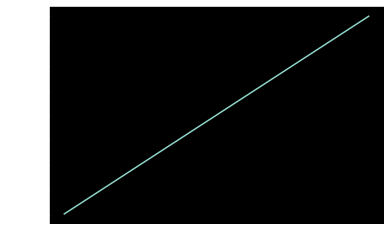

In [ ]:
# amount of variance added at each step
plt.plot(beta);

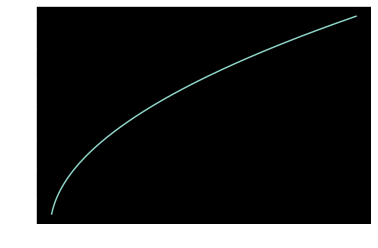

In [ ]:
# amount of standard deviation added at each step
plt.plot(sigma);

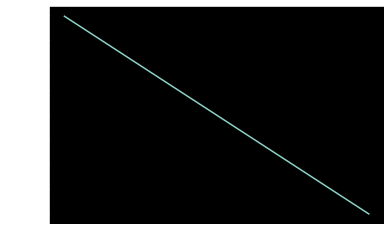

In [ ]:
plt.plot(alpha);

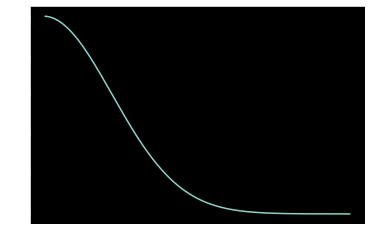

In [ ]:
# cumulative added noise
plt.plot(alphabar);

In [ ]:
def noisify(x0, alphabar):
    # x0 is a batch, alphabar is a schedule
    device = x0.device
    n = len(x0)
    # random steps for the given number of items in a batch
    t = torch.randint(0, n_steps, (n,), dtype = torch.long)
    # create random noise of size equal to the given batch
    eps = torch.rand(x0.shape, device=device)
    # grab values from schedule for given steps
    alphabar_t = alphabar[t].reshape(-1, 1, 1, 1).to(device)
    # make xt a weighted average of noise and original image
    xt = alphabar_t.sqrt()*x0 + (1-alphabar_t).sqrt()*eps
    return (xt, t.to(device)), eps

In [ ]:
(xt,t),epsilon = noisify(xb[:25],alphabar)
t

tensor([641, 878, 122, 898, 301, 568, 682,  19, 312, 107, 594,  46, 799, 355,
        184, 216, 229,  51, 951, 744, 706, 825,  58, 277, 194])

In [ ]:
xb[:25].shape

torch.Size([25, 1, 32, 32])

In [ ]:
torch.randint(0, n_steps, (25,), dtype = torch.long)

tensor([325, 257, 852,  70, 208,  34,  58, 124, 150, 431, 436, 229, 859, 447,
        884, 141, 460, 344, 443, 286, 371, 930, 833, 848, 145])

In [ ]:
alphabar[[999,55,2,330]].reshape(-1,1,1,1)

tensor([[[[4.0358e-05]]],


        [[[9.6436e-01]]],


        [[[9.9964e-01]]],


        [[[3.2513e-01]]]])

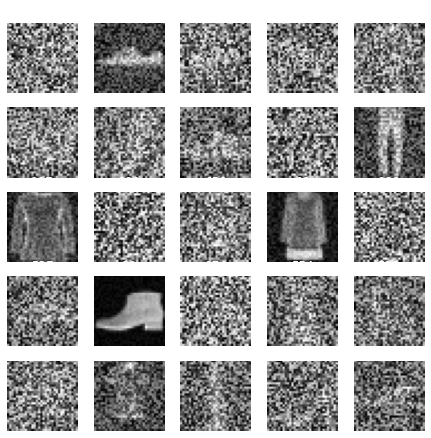

In [ ]:
titles = fc.map_ex(t, '{}')
show_images(xt, imsize=1.5, titles=titles)

Basic algorithm is:
1. Select clean image from the dataset
2. Take a random timestep
3. Get epsilon value
4. Calculate xt

In [ ]:
class DDPMCB(TrainCB):
    order = DeviceCB.order+1
    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        self.n_steps,self.βmin,self.βmax = n_steps,beta_min,beta_max
        # variance schedule, linearly increased with timestep
        self.β = torch.linspace(self.βmin, self.βmax, self.n_steps)
        self.α = 1. - self.β 
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.β.sqrt()

    def predict(self, learn): learn.preds = learn.model(*learn.batch[0]).sample
    
    def before_batch(self, learn):
        device = learn.batch[0].device
        ε = torch.randn(learn.batch[0].shape, device=device)  # noise, x_T
        x0 = learn.batch[0] # original images, x_0
        self.ᾱ = self.ᾱ.to(device)
        n = x0.shape[0]
        # select random timesteps
        t = torch.randint(0, self.n_steps, (n,), device=device, dtype=torch.long)
        ᾱ_t = self.ᾱ[t].reshape(-1, 1, 1, 1).to(device)
        xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε #noisify the image
        # input to our model is noisy image and timestep, ground truth is the noise 
        learn.batch = ((xt, t), ε)
    
    @torch.no_grad()
    def sample(self, model, sz):
        device = next(model.parameters()).device
        x_t = torch.randn(sz, device=device)
        preds = []
        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
            z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
            ᾱ_t1 = self.ᾱ[t-1]  if t > 0 else torch.tensor(1)
            b̄_t = 1 - self.ᾱ[t]
            b̄_t1 = 1 - ᾱ_t1
            noise_pred = learn.model(x_t, t_batch).sample
            x_0_hat = ((x_t - b̄_t.sqrt() * noise_pred)/self.ᾱ[t].sqrt()).clamp(-1,1)
            x0_coeff = ᾱ_t1.sqrt()*(1-self.α[t])/b̄_t
            xt_coeff = self.α[t].sqrt()*b̄_t1/b̄_t
            x_t = x_0_hat*x0_coeff + x_t*xt_coeff + self.σ[t]*z
            preds.append(x_t.cpu())
        return preds

Okay now we're ready to train a model!

Let's create our `Learner`. We'll add our callbacks and train with MSE loss.

We specify the number of timesteps and the minimum and maximum variance for the DDPM model.

In [ ]:
lr = 4e-3
epochs = 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=optim.Adam)

loss,epoch,train
0.056,0,train
0.024,0,eval
0.021,1,train
0.021,1,eval
0.018,2,train
0.018,2,eval
0.017,3,train
0.017,3,eval
0.016,4,train
0.016,4,eval


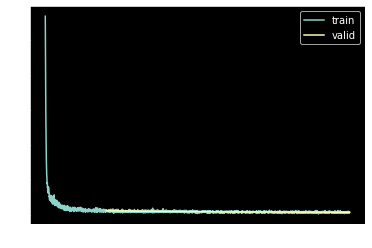

In [ ]:
learn.fit(epochs)

In [ ]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)

In [ ]:
torch.save(learn.model, mdl_path/'fashion_ddpm.pkl')

In [ ]:
learn.model = torch.load(mdl_path/'fashion_ddpm.pkl')

## Sampling

In [ ]:
set_seed(42)
samples = ddpm_cb.sample(learn. model, (16,1,32,32))
len(samples)

1000

We take last items that represent the closest image

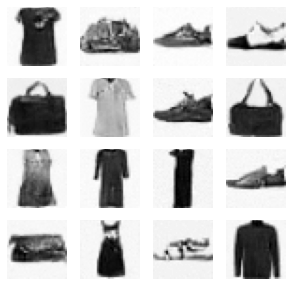

In [ ]:
show_images(-samples[-1], figsize=(5,5))

In [ ]:
%matplotlib auto
import matplotlib.animation as animation
from IPython.display import display, HTML

fig, ax = plt.subplots(figsize=(3,3))
def _show_i(i): return show_image(-samples[i][9], ax=ax, animated=True).get_images()
r = L.range(800,990, 5)+L.range(990,1000)+[999]*10
ims = r.map(_show_i)

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=3000)
display(HTML(animate.to_html5_video()))

Using matplotlib backend: <object object>


Note that I only take the steps between 800 and 1000 since most of the previous steps are actually quite noisy. This is a limitation of the noise schedule used for small images, and papers like Improved DDPM suggest other noise schedules for this purpose! (Some potential homework: try out the noise schedule from Improved DDPM and see if it helps.)